## model try


### Load libraries

In [7]:
import cv2
import os
import tqdm
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from tqdm import tqdm
import numpy as np

from PIL import Image

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch
import matplotlib.pyplot as plt

#DERT model
from transformers import DetrForObjectDetection
from transformers import DetrConfig, DetrForObjectDetection,ConditionalDetrForObjectDetection,AutoImageProcessor



In [16]:
print(os.getcwd())

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


Load model state


In [20]:
from transformers import DetrConfig, DetrForObjectDetection

config = DetrConfig.from_pretrained('facebook/detr-resnet-50',revision="no_timm",num_labels=2,id2label={0:"text",1:"fracture"},
                                                             ignore_mismatched_sizes=True) 
                                                             
model = DetrForObjectDetection(config)
best_model = torch.load(f'../models/DETR_16vatch_lr13-4_AdamW/Best_val_DETR_Model.pt',map_location=torch.device('cpu'))
model.load_state_dict(best_model['model_state_dict'])
print(best_model['best_loss'])

0.8462895695899373


In [25]:
model

ConditionalDetrForObjectDetection(
  (model): ConditionalDetrModel(
    (backbone): ConditionalDetrConvModel(
      (conv_encoder): ConditionalDetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): ConditionalDetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): ConditionalDetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): ConditionalDetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (

In [4]:

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [2]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

Load dataset

In [3]:
import sys
sys.path.append('../')
%cd ..
from src.data.my_rpg_dataset import CocoDetection
from src.data.my_rpg_dataset import collate_fn_COCO
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(path_folder="data", processor=processor,status='test')
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_COCO, batch_size=1, shuffle=False,num_workers=0)

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [13]:
evaluator = CocoEvaluator(coco_gt=train_dataset.coco, iou_types=["bbox"])

In [8]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [9]:
model.eval()

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [14]:
#evaluator.coco_eval['bbox'].params.catIds = [1]

print("Running evaluation...")
for idx, batch in enumerate(tqdm(train_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes,threshold=0.7)
    
    #Apply the nms function to the boxes 
    nms_results = []
    for result in results:
        # Get the boxes, scores, and labels from the current dictionary
        boxes = result['boxes']
        scores = result['scores']
        pred_labels = result['labels']
        
        # Apply NMS to the boxes
        keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
        
        # Create a new dictionary with the NMS-filtered boxes
        result_nms = {}
        result_nms['scores'] = scores[keep]
        result_nms['labels'] = pred_labels[keep]
        result_nms['boxes'] = boxes[keep]
        
        # Append the new dictionary to the `nms_results` list
        nms_results.append(result_nms)
    
    # provide to metric
    # metric expects a list of dictionaries, each item 
    # containing image_id, category_id, bbox and score keys 
    prediction = {target['image_id'].item(): output for target, output in zip(labels, nms_results)}
    predictions = prepare_for_coco_detection(prediction)
    evaluator.update(predictions)
    if idx == 1 : break

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/3022 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

In [15]:
prediction

{2: {'scores': tensor([0.9983]),
  'labels': tensor([0]),
  'boxes': tensor([[241.1729, 771.6467, 264.3885, 806.8659]])}}

In [16]:
empty_ann = {'scores': torch.tensor([0.0]), 
              'labels': torch.tensor([0]), 
              'boxes': torch.tensor([[0.0, 0.0, 0.0, 0.0]])}
predictions = {labels[0]['image_id'].item(): empty_ann}

In [17]:
predictions

{2: {'scores': tensor([0.]),
  'labels': tensor([0]),
  'boxes': tensor([[0., 0., 0., 0.]])}}

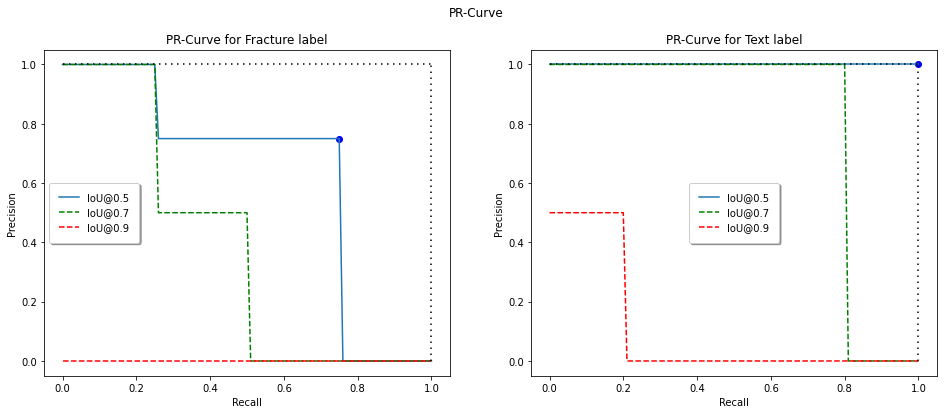

In [25]:
import numpy as np
import matplotlib.pyplot as plt 

coco_eval = evaluator.coco_eval['bbox']

all_precision = coco_eval.eval['precision']

pr_5 = all_precision[0, :, 1, 0, 2] # data for IoU@0.5
pr_7 = all_precision[4, :, 1, 0, 2] # data for IoU@0.7
pr_9 = all_precision[8, :, 1, 0, 2] # data for IoU@0.9

x = np.arange(0, 1.01, 0.01)

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot(x, pr_5, label='IoU@0.5')
plt.plot(x, pr_7, '--g',label='IoU@0.7')
plt.plot(x, pr_9, '--r',label='IoU@0.9')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.plot([0,1],  [1,1], linestyle='dashed', dashes=(1,3),color='black')
plt.plot([1,1],  [0,1], linestyle='dashed', dashes=(1,3),color='black')
plt.scatter(coco_eval.eval['recall'][0][1][0][2], coco_eval.eval['precision'][0][int(coco_eval.eval['recall'][0][1][0][2]*100)][1][0][2], label = "Best Trade-off",color = "blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Curve for Fracture label")

pr_5 = all_precision[0, :, 0, 0, 2] # data for IoU@0.5
pr_7 = all_precision[4, :, 0, 0, 2] # data for IoU@0.7
pr_9 = all_precision[8, :, 0, 0, 2] # data for IoU@0.9

plt.subplot(1, 2, 2)
plt.plot(x, pr_5, label='IoU@0.5')
plt.plot(x, pr_7, '--g',label='IoU@0.7')
plt.plot(x, pr_9, '--r',label='IoU@0.9')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.plot([0,1],  [1,1], linestyle='dashed', dashes=(1,3),color='black')
plt.plot([1,1],  [0,1], linestyle='dashed', dashes=(1,3),color='black')
plt.scatter(coco_eval.eval['recall'][0][0][0][2], coco_eval.eval['precision'][0][int(coco_eval.eval['recall'][0][0][0][2]*100)][0][0][2], label = "Best Trade-off",color = "blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-Curve for Text label")

plt.suptitle("PR-Curve")
plt.show()

In [26]:
metrics = coco_eval.stats
f = (coco_eval.eval['recall'][0][1][0][2]*100)
t = (coco_eval.eval['recall'][0][0][0][2]*100)
print("Secondary Evaluation Metrics :\n The AP value on IoU = 0.5 that matters the most is : {:.4f}.\n The Recall of the model for Text label is : {:.4f}. The Precision of the model for Text is : {:.4f}.\n The Recall of the model for Fracture label is : {:.4f}. The Precision of the model for Fracture is : {:.4f}".format(metrics[1], coco_eval.eval['recall'][0][0][0][2], coco_eval.eval['precision'][0][int(t)][0][0][2], coco_eval.eval['recall'][0][1][0][2], coco_eval.eval['precision'][0][int(f)][1][0][2] ))

Secondary Evaluation Metrics :
 The AP value on IoU = 0.5 that matters the most is : 0.8144.
 The Recall of the model for Text label is : 1.0000. The Precision of the model for Text is : 1.0000.
 The Recall of the model for Fracture label is : 0.7500. The Precision of the model for Fracture is : 0.7500


In [28]:
import contextlib
import io

id2label={0:"text",1:"fracture"}
print('---Per-Class Eval---')
for catId in train_dataset.coco.getCatIds():
   
    # Redirect standard output to a null device
    with contextlib.redirect_stdout(io.StringIO()):
        # Call the summarize() function
        evaluator = CocoEvaluator(coco_gt=train_dataset.coco, iou_types=["bbox"])
        evaluator.coco_eval['bbox'].params.catIds = [catId]

        print("Running evaluation...")
        for idx, batch in enumerate(tqdm(train_dataloader)):
            # get the inputs
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask = batch["pixel_mask"].to(device)
            labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

            # forward pass
            with torch.no_grad():
                outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            # turn into a list of dictionaries (one item for each example in the batch)
            orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
            results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
            # provide to metric
            # metric expects a list of dictionaries, each item 
            # containing image_id, category_id, bbox and score keys 
            predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
            predictions = prepare_for_coco_detection(predictions)
            evaluator.update(predictions)
            if idx == 3 : break
            

        evaluator.synchronize_between_processes()
        evaluator.accumulate()
        evaluator.summarize()
    # Get the evaluation metrics
    coco_eval = evaluator.coco_eval['bbox']
    metrics = coco_eval.stats
    print("The AP value on IoU = 0.5 for class {} is : {:.4f}.\n".format(id2label[catId],metrics[1]))

  0%|          | 0/3041 [00:00<?, ?it/s]

---Per-Class Eval---
The AP value on IoU = 0.5 for class text is : 1.0000.



  0%|          | 0/3041 [00:00<?, ?it/s]

The AP value on IoU = 0.5 for class fracture is : 0.6287.



In [57]:
for score, label, box in zip(results[0]["scores"], results[0]["labels"], results[0]["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected text with confidence 0.996 at location [738.74, 559.0, 794.27, 631.82]
Detected fracture with confidence 0.959 at location [273.46, 483.92, 431.31, 569.57]


#### Visualization

In [30]:
cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

In [31]:
id2label

{0: 'text', 1: 'fracture'}

In [81]:
#We can use the image_id in target to know which image it is
pixel_values, target = train_dataset[2]

FileNotFoundError: [Errno 2] No such file or directory: 'data\\../literature/Other/supervisely/wrist/rpg_images/2336_0218251225_02_WRI-L2_F008.png'

In [33]:
target

{'size': tensor([1332,  726]), 'image_id': tensor([4]), 'class_labels': tensor([0]), 'boxes': tensor([[0.9424, 0.8687, 0.0987, 0.0672]]), 'area': tensor([6413.3599]), 'iscrowd': tensor([0]), 'orig_size': tensor([1116,  608])}

In [35]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 1332, 726])


In [36]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [63]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [40]:
%cd notebooks

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [42]:
annotations = train_dataset.coco.imgToAnns[image_id]

In [43]:
annotations

[{'id': 9,
  'image_id': 4,
  'category_id': 0,
  'bbox': [543, 932, 60, 75],
  'area': 4500,
  'segmentation': [],
  'iscrowd': 0}]

In [5]:
# load image based on ID
image_id = target['image_id'].item()
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))
target_annotations = train_dataset.coco.imgToAnns[image_id]


# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.5)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

NameError: name 'target' is not defined

In [78]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes,target_labels,target_boxes,confidence=0.5):
    fig = plt.figure(figsize=(15,10))

    fig.add_subplot(1, 2, 1)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={0:"text",1:"fracture"}
    for label, box,c  in zip(target_labels.tolist(), target_boxes.tolist(), colors):
        x,y,w,h = tuple(box)
        ax.add_patch(plt.Rectangle((x,y),w,h,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}'
        ax.text(x, y, text, fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("Target Image and Boxes")
    ########################################################################################################
    fig.add_subplot(1, 2, 2)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    colors = COLORS * 100
    id2label = id2label={0:"text",1:"fracture"}
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        if score >= confidence:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            text = f'{model.config.id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("Model prediction")


    plt.show()

In [79]:
torch.tensor(target_annotations[0]['bbox'])

tensor([543, 932,  60,  75])

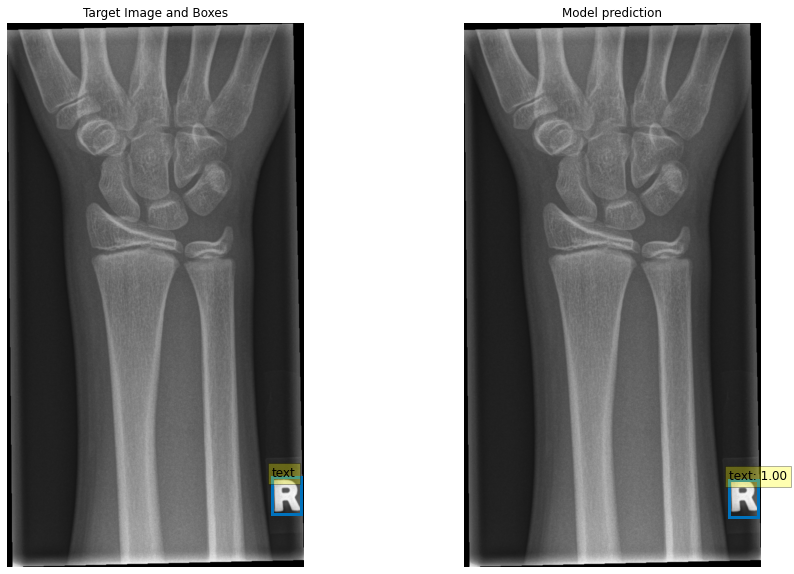

In [80]:
plot_results(image, results['scores'], results['labels'], results['boxes'],torch.tensor([target_annotations[0]['category_id']]),torch.tensor([target_annotations[0]['bbox']]))

In [10]:
%cd notebooks

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


Target Image n°5


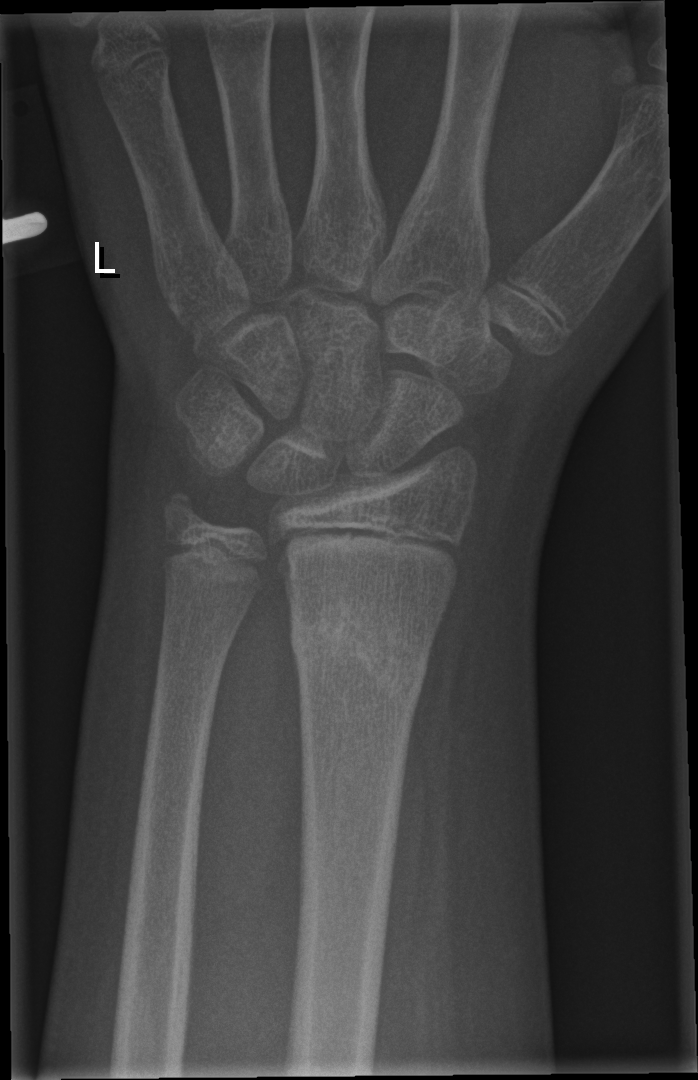

In [13]:
import numpy as np
import os
from PIL import Image, ImageDraw

image_id = 5

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
print('Target Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image)

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image